In [15]:
# Re-import needed modules after reset
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load the JSON data from file
file_path = Path("url_data2_updated.json")
with open(file_path, "r") as f:
    data = json.load(f)

# Recreate enhanced compliance records
enhanced_compliance_records = []

def is_not_nully(value):
    return value is not None and value != "" and value!= "None" and value != "N/A"

verification_data = {}
verification_data["verified"] = 0
verification_data["human"] = 0
verification_data["nano"] = 0
verification_data["old"] = 0

ctr = 0
for domain, details in data.items():
    if details.get("verified"):
        verification_data["verified"] += 1
        if details.get("human"):
            verification_data["human"] += 1
        elif details.get("nano"):
            verification_data["nano"] += 1
            print("website {} is verified using gemini nano".format(domain))
        else:
            verification_data["old"] += 1
            
        external = details.get("external_buttons", {})
        internal = details.get("internal_buttons", [])

        internal_keys = {btn.get("option_name") for btn in internal if "option_name" in btn}
        ctr_prev = ctr
        if "reject_all" in external and "accept_all" in external:
            button_reject = external["reject_all"]
            button_accept = external["accept_all"]
            for k in ["id", "text"]:
                if button_reject.get(k) == button_accept.get(k) and is_not_nully(button_reject.get(k)):
                    ctr += 1
                    #print("{}. button has same {} for accept and reject in website {}, which is {}".format(ctr, k, domain, button_reject.get(k)))
                    external.pop("reject_all")
                    break
        
        has_reject_all_external = "reject_all" in external
        has_reject_all_internal = "reject_all" in internal_keys
        has_reject_all = has_reject_all_external or has_reject_all_internal

        domain_data = {
            "domain": domain,
            "has_reject_all": has_reject_all,
            "reject_all_location": (
                "external" if has_reject_all_external else
                "internal" if has_reject_all_internal else
                "none"
            ),
            "has_granular_prefs": "marketing" in internal_keys and "performance" in internal_keys,
            "has_manage_prefs": "manage_my_preferences" in external
        }

        enhanced_compliance_records.append(domain_data)

# Question 1: Count dark patterns (reject_all in internal only)
dark_pattern_count = sum(
    entry["reject_all_location"] == "internal" for entry in enhanced_compliance_records
)
no_dark_pattern_count = sum(
    entry["reject_all_location"] == "external" for entry in enhanced_compliance_records
)

# Question 2: Presence of "reject all"
has_reject_all_count = sum(entry["has_reject_all"] for entry in enhanced_compliance_records)
no_reject_all_count = len(enhanced_compliance_records) - has_reject_all_count

# Question 3: Granular preferences
granular_count = sum(entry["has_granular_prefs"] for entry in enhanced_compliance_records)
no_granular_count = len(enhanced_compliance_records) - granular_count

# Question 4: Steps to opt out
step_counts = []
for entry in enhanced_compliance_records:
    if entry["reject_all_location"] == "external":
        step_counts.append(1)
    elif entry["reject_all_location"] == "internal":
        step_counts.append(2)
    elif entry["has_manage_prefs"] and not entry["has_reject_all"]:
        step_counts.append(3)
    else:
        step_counts.append(4)


# Question 5: Verification data
print(f'{verification_data["verified"]} websites are verified, {verification_data["human"]} using human scrapy, {verification_data["nano"]} using gemini nano and {verification_data["old"]} using old scrapy')


website 6play.fr is verified using gemini nano
website abb.com is verified using gemini nano
website all.accor.com is verified using gemini nano
website act.org is verified using gemini nano
website adfc.de is verified using gemini nano
website alz.org is verified using gemini nano
website anydesk.com is verified using gemini nano
website bentley.edu is verified using gemini nano
website bitly.com is verified using gemini nano
website blog4ever.com is verified using gemini nano
website bricklink.com is verified using gemini nano
website bruker.com is verified using gemini nano
website buydomains.com is verified using gemini nano
website cityam.com is verified using gemini nano
website corsair.com is verified using gemini nano
103 websites are verified, 2 using human scrapy, 15 using gemini nano and 86 using old scrapy


In [19]:
ct = 0
for entry in enhanced_compliance_records:
    if (not entry["has_reject_all"]) and (entry):
        print(entry["domain"])
        ct+=1

print(f'{ct} websites do not have reject all button')


350.org
about.me
acs.org
act.org
adb.org
affordablepapers.com
amd.com
americangirl.com
ampproject.org
anydesk.com
apc.com
asu.edu
atlantafed.org
aut.ac.nz
authy.com
avast.com
avira.com
avma.org
awwwards.com
baltimoresun.com
bedbathandbeyond.com
bentley.edu
bitly.com
blizzard.com
bricklink.com
bruker.com
bsa.org
buffalonews.com
businessdailyafrica.com
businesswire.com
buydomains.com
caesars.com
canneslions.com
caravanclub.co.uk
cisco.com
cision.com
clickondetroit.com
cloudimage.io
commonwealthfund.org
computerbase.de
cookieyes.com
criteo.com
dailymotion.com
dc.com
dcist.com
deere.com
designboom.com
devex.com
digitalocean.com
dilbert.com
50 websites do not have reject all button


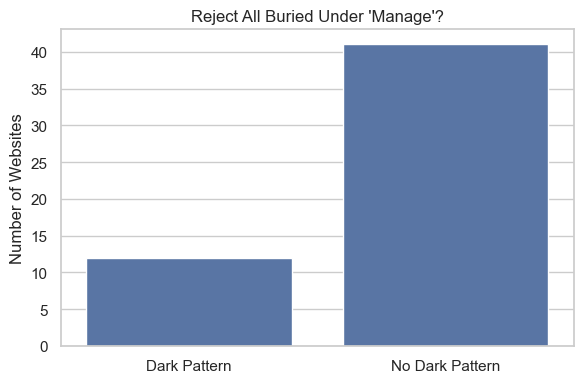

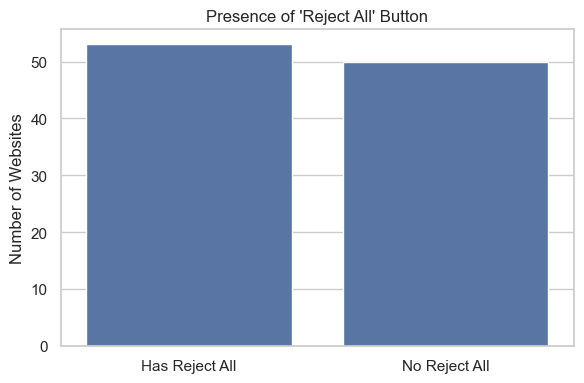

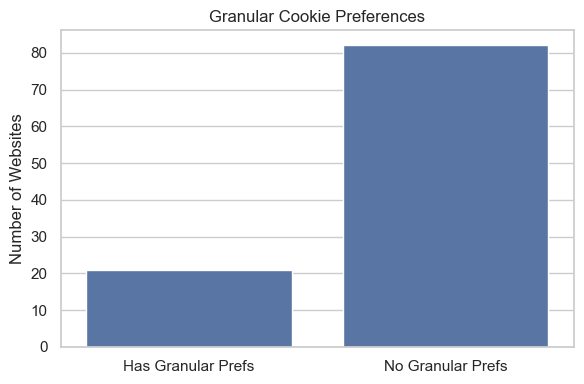

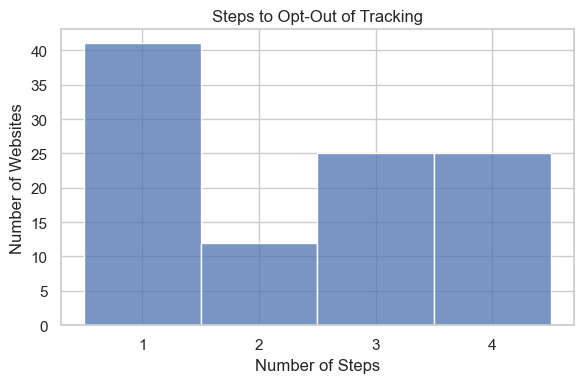

In [17]:
# Plot 1: Dark patterns
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=["Dark Pattern", "No Dark Pattern"], y=[dark_pattern_count, no_dark_pattern_count])
plt.title("Reject All Buried Under 'Manage'?")
plt.ylabel("Number of Websites")
plt.tight_layout()
plt.show()

# Plot 2: Reject All presence
plt.figure(figsize=(6, 4))
sns.barplot(x=["Has Reject All", "No Reject All"], y=[has_reject_all_count, no_reject_all_count])
plt.title("Presence of 'Reject All' Button")
plt.ylabel("Number of Websites")
plt.tight_layout()
plt.show()

# Plot 3: Granular Preferences
plt.figure(figsize=(6, 4))
sns.barplot(x=["Has Granular Prefs", "No Granular Prefs"], y=[granular_count, no_granular_count])
plt.title("Granular Cookie Preferences")
plt.ylabel("Number of Websites")
plt.tight_layout()
plt.show()

# Plot 4: Steps to Opt Out
plt.figure(figsize=(6, 4))
sns.histplot(step_counts, bins=[1, 2, 3, 4, 5], discrete=True)
plt.title("Steps to Opt-Out of Tracking")
plt.xlabel("Number of Steps")
plt.ylabel("Number of Websites")
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()

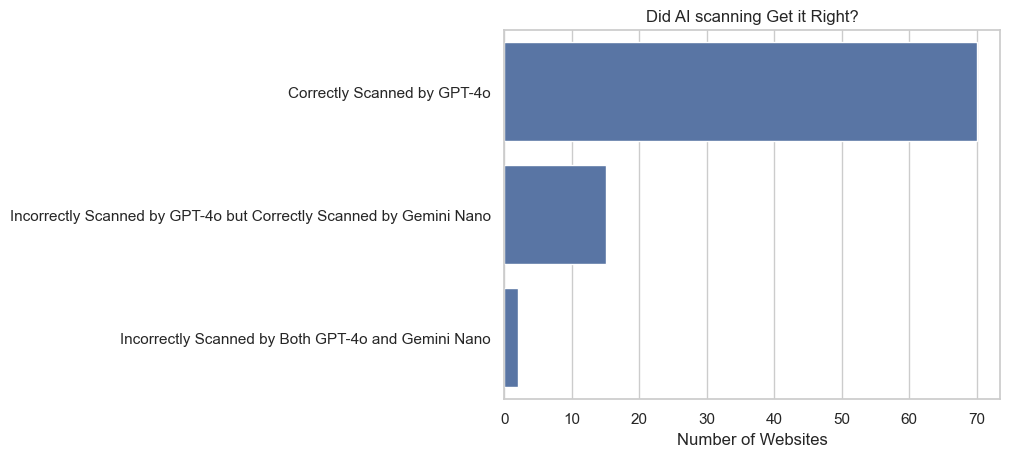

In [11]:
# documentation

# human: true means I (Ram) edited the data
# nano: true means I should eventually use gemini nano data from my device to replace the data here
# verified: false means the data is verified to be wrong
# verified: true means the data is verified to be correct

# Plot 1: Dark patterns
sns.set(style="whitegrid")
plt.figure()
sns.barplot(y=["Correctly Scanned by GPT-4o", "Incorrectly Scanned by GPT-4o but Correctly Scanned by Gemini Nano", "Incorrectly Scanned by Both GPT-4o and Gemini Nano"], x=[70, 15, 2])
plt.title("Did AI scanning Get it Right?")
plt.xlabel("Number of Websites")
plt.show()

In [75]:
# track over time (visualize in terms of proportion vs. count)
# 2 bar charts -> 1st one timeline 
# 2nd one -> no over time (data changing over time would be interesting (collection))

# Word cloud of "reject all names"
# Word cloud of "Accept all names"

# Categorization of websites
# Interactive with other bar charts


In [77]:
# Martini glass idea?
# Not sure if people understadn inherently so guided exploration in the beginning and then at the end
